In [ ]:
# Nama  : MUHAMAD RAYNARD ALIF
# Email : 20523167@students.uii.ac.id

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import Package
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
# Load Data
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, *args, **kwargs)
        generator.class_indices = {v: k for k, v in generator.class_indices.items()}
        return generator

def load_data(data_dir, batch_size=32, img_size=(224, 224), class_mode='categorical', validation_ratio=0.4):
    # Count the total number of images
    total_samples = sum([len(files) for _, _, files in os.walk(data_dir)])

    # Calculate the number of samples for validation
    validation_samples = int(total_samples * validation_ratio)

    train_datagen = CustomImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=validation_ratio
    )

    # Generate batches of augmented data for training and validation
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=True,
        subset='training'  # specify training set
    )

    val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=True,
        subset='validation'  # specify validation set
    )

    return train_generator, val_generator, train_generator.class_indices

def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

def build_model(num_classes, input_shape=(224, 224, 3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Custom callback to stop training after a certain time limit
class TimeoutCallback(Callback):
    def __init__(self, timeout_):
        super(TimeoutCallback, self).__init__()
        self.timeout_ = timeout_
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        current_time = time.time()
        elapsed_time = (current_time - self.start_time) / 60.0  # convert to minutes

        if elapsed_time >= self.timeout_:
            print(f"\nTraining stopped after {self.timeout_} minutes.")
            self.model.stop_training = True

# Train the model with time limit and learning rate schedule
def train_model(model, train_generator, val_generator, epochs=10, timeout_=30):
    def lr_schedule(epoch):
        lr = 0.00001  # The initial learning rate
        if epoch > 10:
            lr *= 0.1
        elif epoch > 5:
            lr *= 0.5
        return lr

    reduce_lr = LearningRateScheduler(lr_schedule)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    timeout_callback = TimeoutCallback(timeout_)

    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[reduce_lr, early_stop, timeout_callback]
    )
    end_time = time.time()

    print(f"Training time: {end_time - start_time} seconds")

    return model, history

def evaluate_model(model, val_generator):
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    return val_loss, val_accuracy


In [ ]:
# Set your data directory
data_dir = '/content/drive/MyDrive/DicodingDataset/rockpaperscissors'

# Set hyperparameters
batch_size = 16
img_size = (224, 224)
epochs = 10
timeOut = 30

# Load and preprocess data with validation split
train_generator, val_generator, class_labels = load_data(data_dir, batch_size=batch_size, img_size=img_size, class_mode='categorical', validation_ratio=0.4)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [ ]:
# Build the model
num_classes = len(train_generator.class_indices)
model = build_model(num_classes, input_shape=(img_size[0], img_size[1], 3))

# Train the model
trained_model, history = train_model(model, train_generator, val_generator, epochs=epochs, timeout_=timeOut)

# Evaluate the model
val_loss, val_accuracy = evaluate_model(trained_model, val_generator)

Epoch 1/10
83/83 [==============================] - 111s 540ms/step - loss: 0.8227 - accuracy: 0.6423 - val_loss: 0.7590 - val_accuracy: 0.7380 - lr: 1.0000e-05
Epoch 2/10
83/83 [==============================] - 48s 579ms/step - loss: 0.3255 - accuracy: 0.8935 - val_loss: 0.4570 - val_accuracy: 0.9119 - lr: 1.0000e-05
Epoch 3/10
83/83 [==============================] - 43s 515ms/step - loss: 0.1763 - accuracy: 0.9513 - val_loss: 0.2478 - val_accuracy: 0.9622 - lr: 1.0000e-05
Epoch 4/10
83/83 [==============================] - 43s 513ms/step - loss: 0.1476 - accuracy: 0.9627 - val_loss: 0.1422 - val_accuracy: 0.9783 - lr: 1.0000e-05
Epoch 5/10
83/83 [==============================] - 45s 539ms/step - loss: 0.0796 - accuracy: 0.9779 - val_loss: 0.0666 - val_accuracy: 0.9863 - lr: 1.0000e-05
Epoch 6/10
83/83 [==============================] - 48s 579ms/step - loss: 0.0759 - accuracy: 0.9802 - val_loss: 0.0311 - val_accuracy: 0.9943 - lr: 1.0000e-05
Epoch 7/10
83/83 [=====================

In [ ]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(model, val_generator):
    val_predictions = model.predict(val_generator)
    val_pred_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = val_generator.classes

    cm = confusion_matrix(val_true_classes, val_pred_classes)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

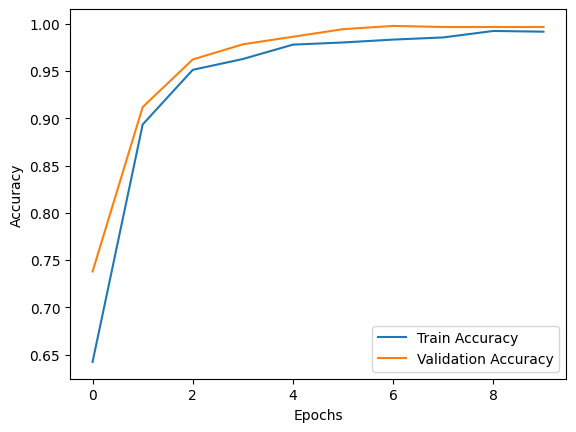

55/55 [==============================] - 18s 289ms/step


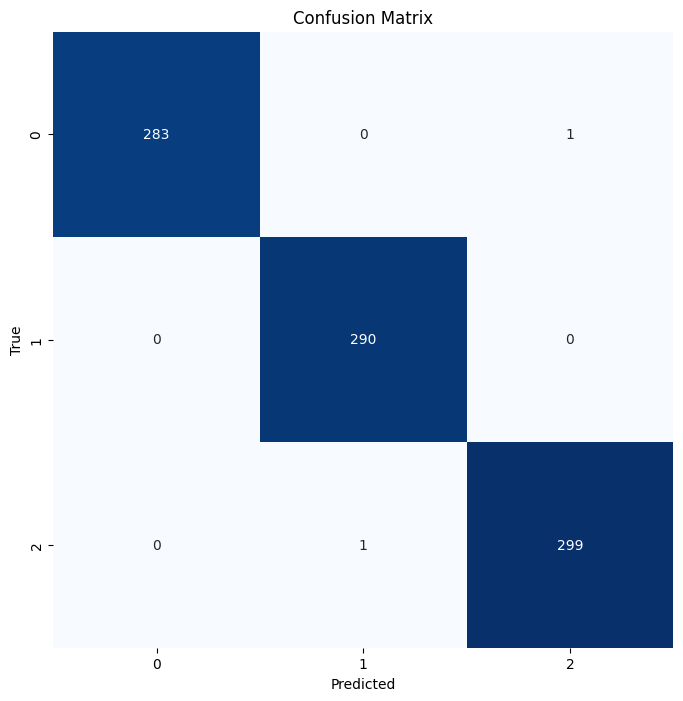

In [ ]:
# Plot training history
plot_training_history(history)

# Plot confusion matrix
plot_confusion_matrix(trained_model, val_generator)


Saving modelTest9.jpeg to modelTest9.jpeg


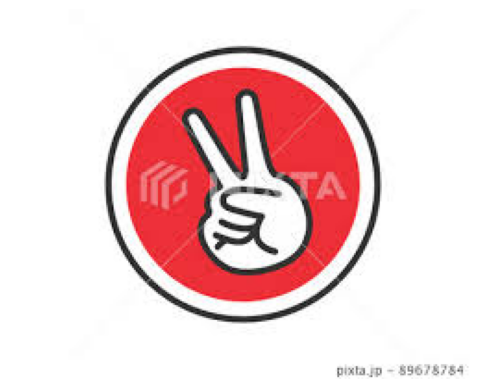

1/1 [==============================] - 0s 28ms/step
Class Labels Dictionary: {0: 'paper', 1: 'rock', 2: 'scissors'}
Class Index: 2
Predicted Class: scissors
Confidence: 0.4414404


In [ ]:
from PIL import Image

def predict_uploaded_image(model, class_labels, target_size=(224, 224)):
    # Prompt user to upload an image
    uploaded = files.upload()

    # Get the first uploaded image
    uploaded_image_path = list(uploaded.keys())[0]

    # Preprocess the uploaded image
    processed_img = preprocess_image(uploaded_image_path, target_size=target_size)
    img = Image.open(uploaded_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Make predictions
    predictions = model.predict(processed_img)
    class_index = np.argmax(predictions, axis=1)[0]

    # Print the predicted class and confidence
    print("Class Labels Dictionary:", class_labels)
    print("Class Index:", class_index)
    print("Predicted Class:", class_labels[class_index])
    print("Confidence:", predictions[0, class_index])

# Predict an uploaded image
predict_uploaded_image(trained_model, class_labels, target_size=img_size)

In [ ]:
def save_model(model, saving_path=None, model_filename=None):
    timestamp = time.strftime("%Y%m%d%H%M%S")
    base_name = model_filename if model_filename else 'model'
    counter = 1
    numbered_filename = f"{base_name}_{timestamp}_{counter}.h5"

    # Check if the filename already exists in the specified path, and increment the counter if needed
    while os.path.exists(os.path.join(saving_path, numbered_filename)):
        counter += 1
        numbered_filename = f"{base_name}_{timestamp}_{counter}.h5"

    # Save the model to the specified path with the numbered filename
    model.save(os.path.join(saving_path, numbered_filename))
    print(f"Model saved as {os.path.join(saving_path, numbered_filename)}")

# Specify the saving path
saving_path = '/content/drive/MyDrive/DicodingDataset/trainedModel/'

# Save the model with a numbered filename to the specified path
save_model(trained_model, saving_path=saving_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as /content/drive/MyDrive/DicodingDataset/trainedModel/model_20240201125558_1.h5


##Nama  : Muhamad Raynard Alif
##Email : 20523167@students.uii.ac.id